In [ ]:
!pip install torchtext==0.15.2 torch==2.0.1

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import random
from sklearn.metrics import classification_report
import nltk

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Set random seeds for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

nltk.download('punkt_tab')
nltk.download('punkt')

# Load training and test datasets
train_df = pd.read_csv("/content/FinalD(for-pytorch).csv")
test_df = pd.read_csv("/content/test.csv")

# Encode labels
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])
test_df["label"] = label_encoder.transform(test_df["label"])

# Tokenization function
def tokenize(text):
    return word_tokenize(text.lower())

# Build vocabulary
vocab = build_vocab_from_iterator([tokenize(text) for text in train_df["comment"]], specials=["<PAD>"])
vocab.set_default_index(vocab["<PAD>"])

# Text processing function
def text_pipeline(text):
    return vocab(tokenize(text))

# Padding function for DataLoader
def collate_batch(batch):
    texts, labels = zip(*batch)
    text_tensors = [torch.tensor(text_pipeline(text), dtype=torch.long) for text in texts]
    text_tensors = pad_sequence(text_tensors, batch_first=True, padding_value=vocab["<PAD>"])
    label_tensors = torch.tensor(labels, dtype=torch.long)
    return text_tensors, label_tensors

# Custom Dataset
class FeedbackDataset(Dataset):
    def __init__(self, comments, labels):
        self.comments = comments
        self.labels = labels

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        return self.comments[idx], self.labels[idx]

# Create Dataset and DataLoader (with fixed seed)
train_dataset = FeedbackDataset(train_df["comment"].tolist(), train_df["label"].tolist())
test_dataset = FeedbackDataset(test_df["comment"].tolist(), test_df["label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch,
                                           worker_init_fn=lambda _: np.random.seed(seed_value),
                                           generator=torch.Generator().manual_seed(seed_value))

test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_batch,
                                          worker_init_fn=lambda _: np.random.seed(seed_value),
                                          generator=torch.Generator().manual_seed(seed_value))

# Define LSTM Model
class FeedbackClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

# Model Initialization
vocab_size = len(vocab)
embed_dim = 50
hidden_dim = 64
output_dim = len(label_encoder.classes_)

model = FeedbackClassifier(vocab_size, embed_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 11
for epoch in range(num_epochs):
    model.train()
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Testing & Metrics Calculation
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.tolist())
        all_preds.extend(predicted.tolist())

# Print Evaluation Metrics
print(f"Test Accuracy: {100 * np.mean(np.array(all_preds) == np.array(all_labels)):.2f}%")
print("\nClassification Report:\n")
report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Test Accuracy: 90.00%

Classification Report:

              precision    recall  f1-score   support

   complaint       0.80      0.80      0.80         5
  compliment       0.80      0.80      0.80         5
     inquiry       1.00      1.00      1.00         5
  suggestion       1.00      1.00      1.00         5

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



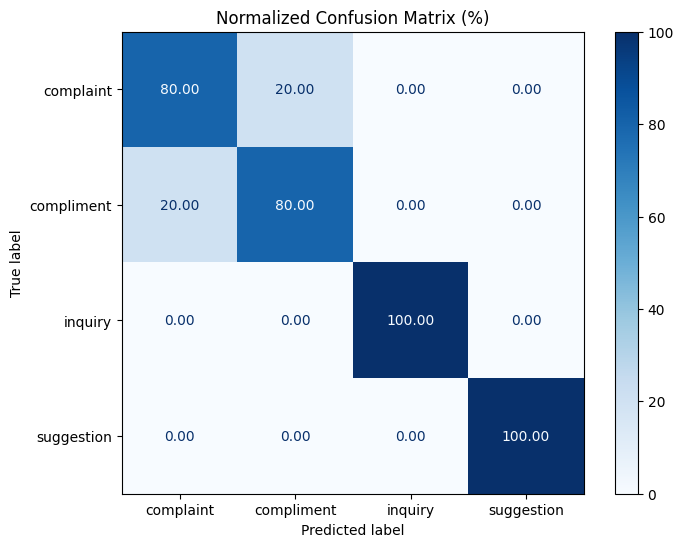

In [23]:
# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Save classification report and confusion matrix
np.save("confusion_matrix_pytorch.npy", cm)


# Convert to percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                       display_labels=label_encoder.classes_).plot(cmap='Blues', ax=ax, values_format=".2f")
plt.title('Normalized Confusion Matrix (%)')
plt.show()

## Saving the classification Report

In [ ]:
import json

In [ ]:
# Save to JSON file
with open('classification_report_pytorch.json', 'w') as f:
    json.dump(report, f)